In [1]:
import numpy as numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [2]:
df = pd.read_csv('CVD_cleaned.csv')
df.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

In [4]:
X = df.drop('Heart_Disease', axis=1)
y = pd.DataFrame(df['Heart_Disease'])

# sample_row = X.loc[0].to_dict()

num_cols = list(X.select_dtypes('number').columns)
cat_cols = list(X.select_dtypes('object').columns)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
sample_row = X.loc[0].to_dict()

In [5]:


num_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessing = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
])

model = LGBMClassifier()
# model = XGBClassifier()

pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('model', model)
])

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.fit_transform(y_valid)

pipeline.fit(X_train, y_train_encoded)
preds = pipeline.predict(X_valid)

print(f'accuracy: {accuracy_score(y_valid_encoded, preds)}')


/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Number of positive: 17495, number of negative: 198702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 216197, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080922 -> initscore=-2.429891
[LightGBM] [Info] Start training from score -2.429891
accuracy: 0.91966068402819


              precision    recall  f1-score   support

          No       0.92      1.00      0.96     85181
         Yes       0.53      0.03      0.06      7476

    accuracy                           0.92     92657
   macro avg       0.73      0.52      0.51     92657
weighted avg       0.89      0.92      0.89     92657



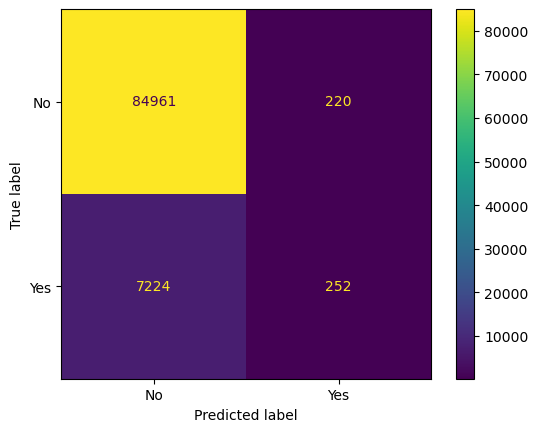

In [6]:
cm = confusion_matrix(y_valid, le.inverse_transform(preds))
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot()
print(classification_report(y_valid, le.inverse_transform(preds)))

In [7]:
import pickle
with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)

In [10]:
from typing import Optional
from pydantic import BaseModel, Field, ValidationError

class Patient(BaseModel):
    General_Health: object
    Checkup: Optional[object] = Field(None, description="Checkup details")
    Exercise: Optional[object] = Field(None, description="Exercise habits")
    Skin_Cancer: Optional[bool] = Field(None, description="History of skin cancer")
    Other_Cancer: Optional[bool] = Field(None, description="History of other cancers")
    Depression: Optional[bool] = Field(None, description="History of depression")
    Diabetes: Optional[bool] = Field(None, description="History of diabetes")
    Arthritis: Optional[bool] = Field(None, description="History of arthritis")
    Sex: Optional[str] = Field(None, description="Sex of the individual")
    Age_Category: Optional[object] = Field(None, description="Age category of the individual")
    Height_cm: float = Field(..., alias="Height_(cm)")
    Weight_kg: float = Field(..., alias="Weight_(kg)")
    BMI: float = Field(..., description="Body Mass Index")
    Smoking_History: Optional[object] = Field(None, description="Smoking history")
    Alcohol_Consumption: float = Field(..., description="Alcohol consumption in liters per week")
    Fruit_Consumption: float = Field(..., description="Fruit consumption in servings per day")
    Green_Vegetables_Consumption: float = Field(..., description="Green vegetables consumption in servings per day")
    FriedPotato_Consumption: float = Field(..., description="Fried potato consumption in servings per week")

with open('pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    loaded_le = pickle.load(file)

print(sample_row)
patient = Patient(**sample_row)
inputs = pd.DataFrame([patient.model_dump(by_alias=True)])
pred = loaded_pipeline.predict(inputs)
loaded_le.inverse_transform(pred)[0]

{'General_Health': 'Poor', 'Checkup': 'Within the past 2 years', 'Exercise': 'No', 'Skin_Cancer': 'No', 'Other_Cancer': 'No', 'Depression': 'No', 'Diabetes': 'No', 'Arthritis': 'Yes', 'Sex': 'Female', 'Age_Category': '70-74', 'Height_(cm)': 150.0, 'Weight_(kg)': 32.66, 'BMI': 14.54, 'Smoking_History': 'Yes', 'Alcohol_Consumption': 0.0, 'Fruit_Consumption': 30.0, 'Green_Vegetables_Consumption': 16.0, 'FriedPotato_Consumption': 12.0}


'No'

In [81]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        patient = Patient(**request.json)
        inputs = pd.DataFrame([patient.model_dump(by_alias=True)])
        pred = loaded_pipeline.predict(inputs)
        actual_pred = loaded_le.inverse_transform(pred)[0]
        response = {
            'prediction': actual_pred
        }
        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [09/Oct/2024 10:18:21] "POST /predict HTTP/1.1" 200 -
